In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '제모제'만 빼서 df생성
item = '제모제'
grouped_by = 'date'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [ ]:
# train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = lv_day_w.loc[:,'temp':]
# target = lv_day_w.loc[:,'qty']

##### 날씨 소셜 전부 사용할 시 : 폭망 

# 날씨만 

In [5]:
list_col = ['temp', 'cloud', 'wind', 'lgt_time','snow', 'rain','PM10']
lowVIF(w,15,list_col)

,VIF_Factor,features
0,1.047669,snow
1,1.305399,rain
2,3.867186,temp
3,4.765719,PM10
4,6.540650,cloud
5,8.176526,lgt_time
6,8.996828,wind


In [6]:
# list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
#               'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
lv_day_w = lv_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = lv_day_w.loc[:,'temp':'PM10']
target = lv_day_w.loc[:,'qty']

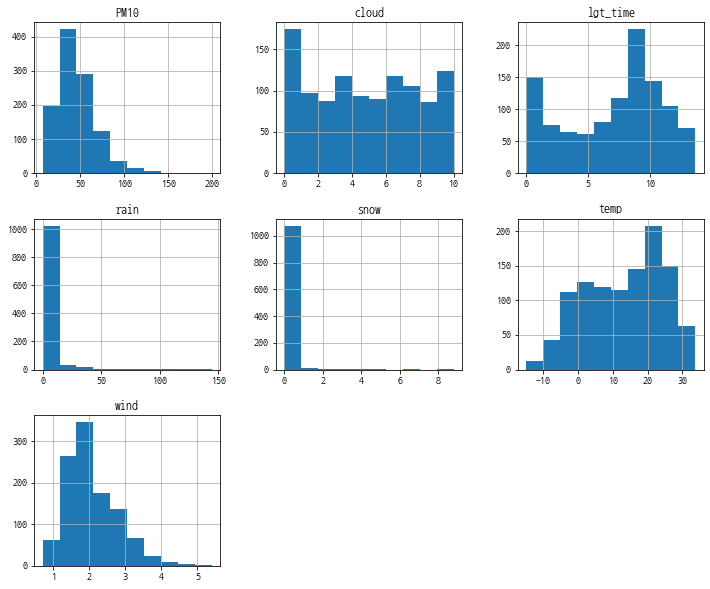

In [7]:
combined = combined
combined.hist(figsize = (12,10))
plt.show()

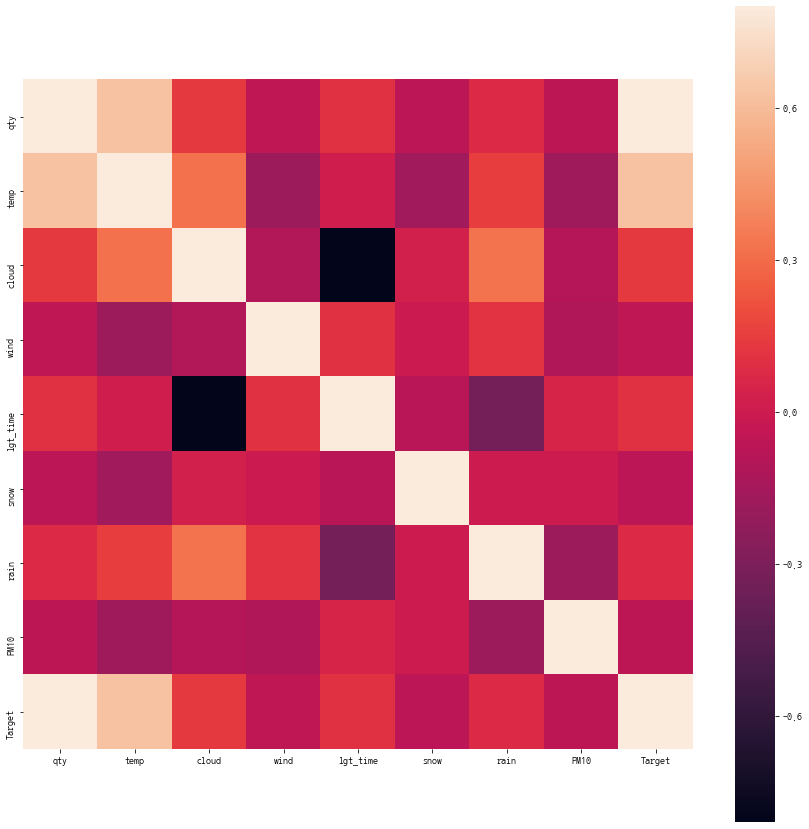

In [8]:
train_data = train_data
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [9]:
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 7)

In [10]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0718 10:38:19.989579  6536 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 10:38:20.004845  6536 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 10:38:20.006843  6536 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0718 10:38:20.064692  6536 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


#### =========='xxxxxxxyyyyyzzzzz.hdf5'파일이 안주어지면 실행.(있으면 실행 필요없음)==========

In [11]:
checkpoint_name = 'LV(lowVIF05)-'+item+grouped_by+'-Weigh-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [28]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 16:40:46.438265  2356 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 16:40:46.541987  2356 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 559us/step - loss: 1602.6903 - mean_absolute_error: 1602.6903 - val_loss: 850.9716 - val_mean_absolute_error: 850.9716

Epoch 00001: val_loss improved from inf to 850.97158, saving model to LV(lowVIF05)-제모제date-Weigh-001--850.97158.hdf5
Epoch 2/500
585/585 [==============================] - 0s 77us/step - loss: 1235.5663 - mean_absolute_error: 1235.5663 - val_loss: 729.5727 - val_mean_absolute_error: 729.5727

Epoch 00002: val_loss improved from 850.97158 to 729.57266, saving model to LV(lowVIF05)-제모제date-Weigh-002--729.57266.hdf5
Epoch 3/500
585/585 [==============================] - 0s 77us/step - loss: 880.2847 - mean_absolute_error: 880.2847 - val_loss: 674.9568 - val_mean_absolute_error: 674.9568

Epoch 00003: val_loss improved from 729.57266 to 674.95684, saving model to LV(lowVIF05)-제모제date-Weigh-003--674.95684.hdf5
Epoch 4/500
585/585 [==============================] - 0s 75u

585/585 [==============================] - 0s 78us/step - loss: 636.7634 - mean_absolute_error: 636.7634 - val_loss: 627.1090 - val_mean_absolute_error: 627.1090

Epoch 00070: val_loss did not improve from 606.89188
Epoch 71/500
585/585 [==============================] - 0s 80us/step - loss: 645.4763 - mean_absolute_error: 645.4763 - val_loss: 604.2100 - val_mean_absolute_error: 604.2100

Epoch 00071: val_loss improved from 606.89188 to 604.21001, saving model to LV(lowVIF05)-제모제date-Weigh-071--604.21001.hdf5
Epoch 72/500
585/585 [==============================] - 0s 77us/step - loss: 646.0665 - mean_absolute_error: 646.0665 - val_loss: 704.7618 - val_mean_absolute_error: 704.7618

Epoch 00072: val_loss did not improve from 604.21001
Epoch 73/500
585/585 [==============================] - 0s 70us/step - loss: 635.6920 - mean_absolute_error: 635.6920 - val_loss: 785.1968 - val_mean_absolute_error: 785.1968

Epoch 00073: val_loss did not improve from 604.21001
Epoch 74/500
585/585 [=====


Epoch 00140: val_loss did not improve from 558.69106
Epoch 141/500
585/585 [==============================] - 0s 77us/step - loss: 619.7940 - mean_absolute_error: 619.7940 - val_loss: 617.6363 - val_mean_absolute_error: 617.6363

Epoch 00141: val_loss did not improve from 558.69106
Epoch 142/500
585/585 [==============================] - 0s 73us/step - loss: 606.8968 - mean_absolute_error: 606.8968 - val_loss: 720.4933 - val_mean_absolute_error: 720.4933

Epoch 00142: val_loss did not improve from 558.69106
Epoch 143/500
585/585 [==============================] - 0s 73us/step - loss: 608.0885 - mean_absolute_error: 608.0885 - val_loss: 620.4974 - val_mean_absolute_error: 620.4974

Epoch 00143: val_loss did not improve from 558.69106
Epoch 144/500
585/585 [==============================] - 0s 72us/step - loss: 611.7219 - mean_absolute_error: 611.7219 - val_loss: 626.3805 - val_mean_absolute_error: 626.3805

Epoch 00144: val_loss did not improve from 558.69106
Epoch 145/500
585/585 [===

585/585 [==============================] - 0s 73us/step - loss: 608.6038 - mean_absolute_error: 608.6038 - val_loss: 584.7990 - val_mean_absolute_error: 584.7990

Epoch 00211: val_loss did not improve from 547.66269
Epoch 212/500
585/585 [==============================] - 0s 77us/step - loss: 602.5350 - mean_absolute_error: 602.5350 - val_loss: 712.6383 - val_mean_absolute_error: 712.6383

Epoch 00212: val_loss did not improve from 547.66269
Epoch 213/500
585/585 [==============================] - 0s 73us/step - loss: 595.2008 - mean_absolute_error: 595.2008 - val_loss: 640.2397 - val_mean_absolute_error: 640.2397

Epoch 00213: val_loss did not improve from 547.66269
Epoch 214/500
585/585 [==============================] - 0s 75us/step - loss: 588.4052 - mean_absolute_error: 588.4052 - val_loss: 683.5044 - val_mean_absolute_error: 683.5044

Epoch 00214: val_loss did not improve from 547.66269
Epoch 215/500
585/585 [==============================] - 0s 73us/step - loss: 583.9418 - mean_


Epoch 00281: val_loss did not improve from 505.80857
Epoch 282/500
585/585 [==============================] - 0s 73us/step - loss: 565.8995 - mean_absolute_error: 565.8995 - val_loss: 739.2751 - val_mean_absolute_error: 739.2751

Epoch 00282: val_loss did not improve from 505.80857
Epoch 283/500
585/585 [==============================] - 0s 72us/step - loss: 591.1119 - mean_absolute_error: 591.1119 - val_loss: 586.2485 - val_mean_absolute_error: 586.2485

Epoch 00283: val_loss did not improve from 505.80857
Epoch 284/500
585/585 [==============================] - 0s 73us/step - loss: 566.2406 - mean_absolute_error: 566.2406 - val_loss: 630.0636 - val_mean_absolute_error: 630.0636

Epoch 00284: val_loss did not improve from 505.80857
Epoch 285/500
585/585 [==============================] - 0s 73us/step - loss: 567.5535 - mean_absolute_error: 567.5535 - val_loss: 617.3182 - val_mean_absolute_error: 617.3182

Epoch 00285: val_loss did not improve from 505.80857
Epoch 286/500
585/585 [===


Epoch 00352: val_loss did not improve from 505.80857
Epoch 353/500
585/585 [==============================] - 0s 78us/step - loss: 560.8153 - mean_absolute_error: 560.8153 - val_loss: 671.3493 - val_mean_absolute_error: 671.3493

Epoch 00353: val_loss did not improve from 505.80857
Epoch 354/500
585/585 [==============================] - 0s 78us/step - loss: 540.1192 - mean_absolute_error: 540.1192 - val_loss: 515.5105 - val_mean_absolute_error: 515.5105

Epoch 00354: val_loss did not improve from 505.80857
Epoch 355/500
585/585 [==============================] - 0s 75us/step - loss: 538.9978 - mean_absolute_error: 538.9978 - val_loss: 698.6206 - val_mean_absolute_error: 698.6206

Epoch 00355: val_loss did not improve from 505.80857
Epoch 356/500
585/585 [==============================] - 0s 73us/step - loss: 534.5280 - mean_absolute_error: 534.5280 - val_loss: 636.1822 - val_mean_absolute_error: 636.1822

Epoch 00356: val_loss did not improve from 505.80857
Epoch 357/500
585/585 [===


Epoch 00423: val_loss did not improve from 505.80857
Epoch 424/500
585/585 [==============================] - 0s 95us/step - loss: 505.7682 - mean_absolute_error: 505.7682 - val_loss: 666.3229 - val_mean_absolute_error: 666.3229

Epoch 00424: val_loss did not improve from 505.80857
Epoch 425/500
585/585 [==============================] - 0s 92us/step - loss: 504.0138 - mean_absolute_error: 504.0138 - val_loss: 665.4846 - val_mean_absolute_error: 665.4846

Epoch 00425: val_loss did not improve from 505.80857
Epoch 426/500
585/585 [==============================] - 0s 87us/step - loss: 506.6313 - mean_absolute_error: 506.6313 - val_loss: 559.8295 - val_mean_absolute_error: 559.8295

Epoch 00426: val_loss did not improve from 505.80857
Epoch 427/500
585/585 [==============================] - 0s 87us/step - loss: 525.4849 - mean_absolute_error: 525.4849 - val_loss: 644.0667 - val_mean_absolute_error: 644.0667

Epoch 00427: val_loss did not improve from 505.80857
Epoch 428/500
585/585 [===


Epoch 00494: val_loss did not improve from 505.80857
Epoch 495/500
585/585 [==============================] - 0s 109us/step - loss: 487.3104 - mean_absolute_error: 487.3104 - val_loss: 703.9913 - val_mean_absolute_error: 703.9913

Epoch 00495: val_loss did not improve from 505.80857
Epoch 496/500
585/585 [==============================] - 0s 102us/step - loss: 499.0065 - mean_absolute_error: 499.0065 - val_loss: 660.8259 - val_mean_absolute_error: 660.8259

Epoch 00496: val_loss did not improve from 505.80857
Epoch 497/500
585/585 [==============================] - 0s 94us/step - loss: 477.8273 - mean_absolute_error: 477.8273 - val_loss: 689.9355 - val_mean_absolute_error: 689.9355

Epoch 00497: val_loss did not improve from 505.80857
Epoch 498/500
585/585 [==============================] - 0s 102us/step - loss: 489.2663 - mean_absolute_error: 489.2663 - val_loss: 650.4772 - val_mean_absolute_error: 650.4772

Epoch 00498: val_loss did not improve from 505.80857
Epoch 499/500
585/585 [

#### ====================================================================================================

In [29]:
# Load wights file of the best model :
wights_file = 'LV(lowVIF05)-제모제date-Weigh-238--505.80857.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [30]:
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [31]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.2f}'.format(model.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(model.score(val_X, val_y)))

Random forest validation MAE =  673.1229508196722


In [32]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.2f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(XGBModel.score(val_X, val_y)))

[16:41:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  684.0942441179453


In [33]:
combined = lv_day_w.loc[:,'temp':]
# combined = lv_day_w.loc[:,'temp':'PM25']
target = lv_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = lv_day_w['date']
result_df['qty'] = lv_day_w.loc[:,'qty']
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1094, 1)
randomforest 예상 (1094,)
XGBpredictions (1094,)


In [34]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

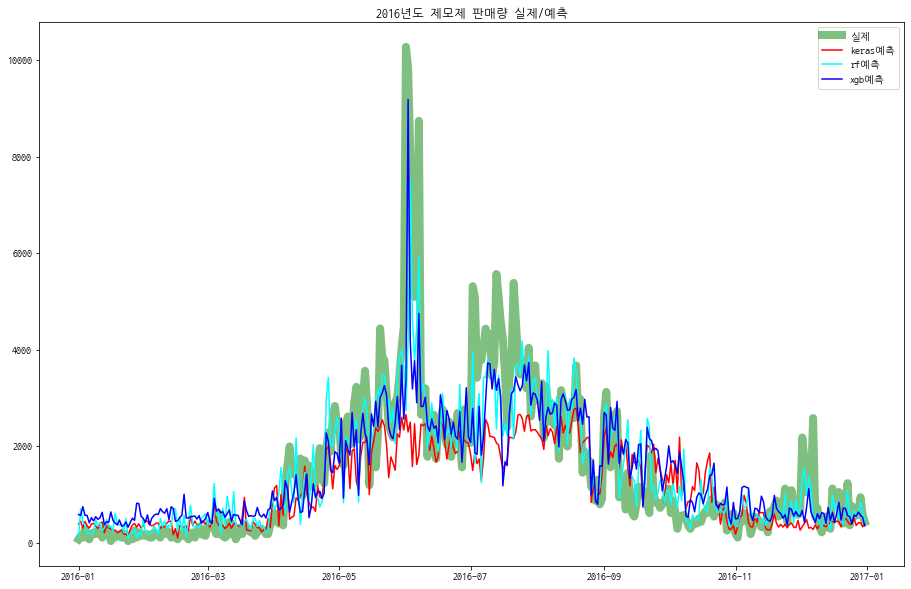

In [35]:
# 2016
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
plt.show()

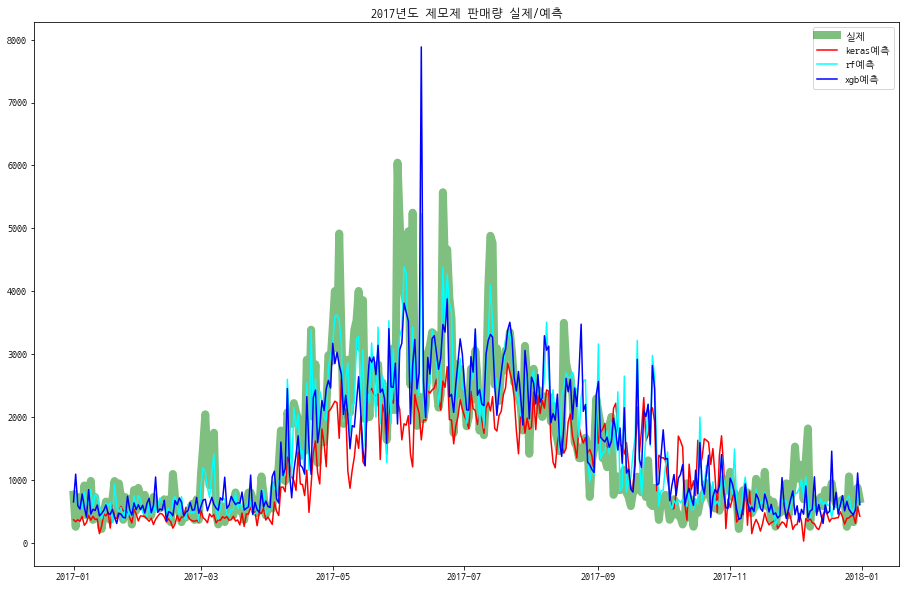

In [36]:
# 2017
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
plt.legend()
plt.show()

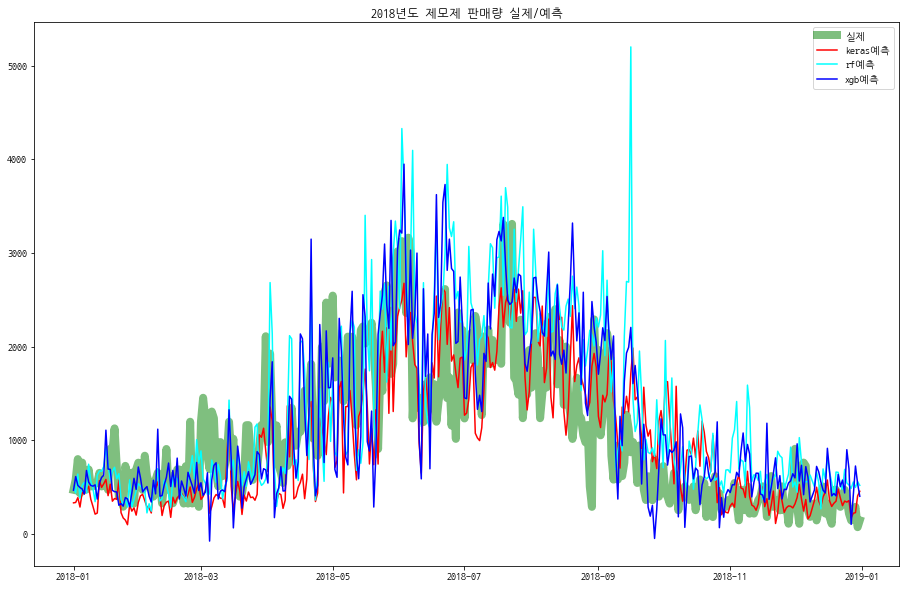

In [37]:
# 2018
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
plt.legend()
plt.show()

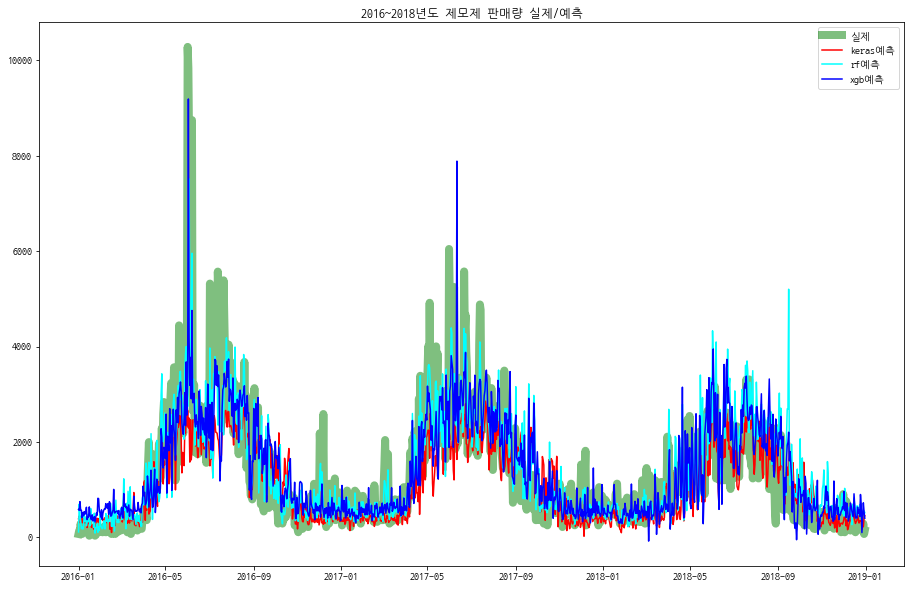

In [38]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.date,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(result_df.date,result_df.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(result_df.date,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(result_df.date,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.legend()
plt.show()

In [39]:
orginal_mean = np.mean(result_df.qty)
result_df['qtyMinusMean'] = (result_df.qty - orginal_mean )
result_df['qtyMinusMeanSquared'] = (result_df.qty - orginal_mean )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty - orginal_mean)**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty - orginal_mean)**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty - orginal_mean)**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.4455366531134215
rf R-sq 0.7906411873001862
xgb R-sq 0.7052114524509089


In [40]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict_lowVIF05.csv', encoding='utf-8', index=False)